In [4]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [14]:
pip install --upgrade tensorflow-datasets


Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the extracted images directory
images_dir = '/Users/mikeredshaw/tensorflow_datasets/stanford_dogs/0.2.0/Images'

# Create an ImageDataGenerator for data augmentation (optional)
data_generator = ImageDataGenerator(rescale=1./255)

# Load images from directory using the data generator
train_data_gen = data_generator.flow_from_directory(
    images_dir,
    target_size=(224, 224),  # You can change the size to what you need
    batch_size=32,
    class_mode='categorical'  # for multi-class classification
)

# You can now use `train_data_gen` as your input to model.fit in place of tfds.load


Found 20580 images belonging to 120 classes.


tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_dir='/Users/mikeredshaw/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
        

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /Users/mikeredshaw/tensorflow_datasets/stanford_dogs/0.2.0/stanford_dogs-train.tfrecord-00000-of-00004; No such file or directory [Op:IteratorGetNext] name: 

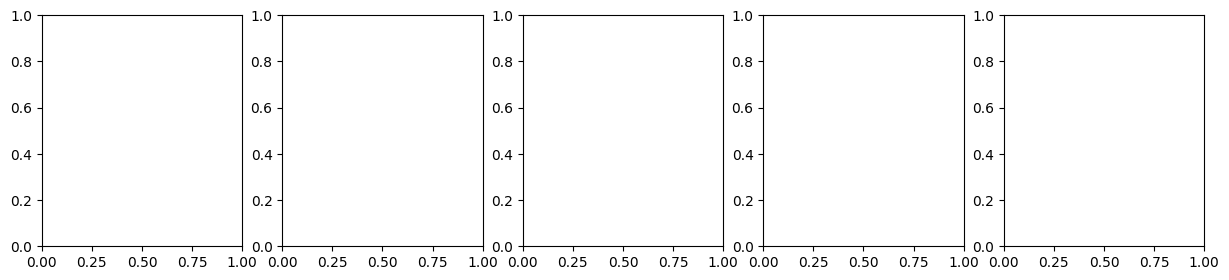

In [16]:
def load_and_display_images(dataset_name, num_images=5):
    # Load the dataset with forced download
    dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True, download=True)

    # Display dataset information
    print(info)

    # Retrieve the first few examples from the training set
    train_dataset = dataset['train']
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for i, (image, label) in enumerate(train_dataset.take(num_images)):
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label.numpy()}")
        axes[i].axis('off')

    plt.show()

# Call the function to load and display images from the Stanford Dogs dataset
load_and_display_images('stanford_dogs', num_images=5)



In [7]:
def load_and_preprocess_dataset(train_size, test_size):

    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True,
        download = True
    )

    def preprocess(image, label):
        image = tf.image.resize(image, (28,28))
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    train_dataset = train_dataset.take(train_size)
    test_dataset = test_dataset.take(test_size)

    X_train, y_train = [], []
    for image, label in tfds.as_numpy(train_dataset):
        X_train.append(image)
        y_train.append(label)

    X_test, y_test = [], []
    for image, label in tfds.as_numpy(test_dataset):
        X_test.append(image)
        y_test.append(label)

    # Reshape and convert lists to numpy arrays
    X_train = np.array(X_train).reshape(-1, 28 * 28 * 3)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 28 * 28 * 3)
    y_test = np.array(y_test).reshape(-1, 1)

    # Scaling
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    # One-hot encoding
    OH = OneHotEncoder(categories='auto', sparse=False)
    y_train = OH.fit_transform(y_train)
    y_test = OH.transform(y_test)

    return X_train, X_test, y_train, y_test

In [113]:
X_train, X_test, y_train, y_test = load_and_preprocess_dataset(12000,8580)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (12000, 2352)
y_train: (12000, 120)
X_test: (8580, 2352)
y_test: (8580, 120)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [114]:
X_train.shape

(12000, 2352)

In [115]:
X_test.shape #Have to change the shape of the train/ test

(8580, 2352)

In [116]:
X_train = X_train.reshape(X_train.shape[0],28,28,3)
X_test = X_test.reshape(X_test.shape[0],28,28,3)

In [117]:
from tensorflow.keras import layers

In [118]:
def simple_model(initializer, activation='relu'):
    return tf.keras.Sequential([layers.Dense(32, activation, input_shape=(28,28,3), kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(120, activation = 'softmax', kernel_initializer=tf.keras.initializers.glorot_normal())
    ])

In [119]:
alexnet_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(48,(3,3), activation='relu', padding='same', input_shape=(28,28,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5), #after every Dense layer we add. adropout layer to randomly drop =
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax') #10 for categories, end with softmax
])

In [120]:
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [121]:
alexnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 48)        1344      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 48)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       55424     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 192)         221376    
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 192)        

In [124]:
alexnet_history = alexnet_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/20
375/375 [==============================] - 16s 43ms/step - loss: 4.7890 - accuracy: 0.0055 - val_loss: 4.7874 - val_accuracy: 0.0133
Epoch 2/20
375/375 [==============================] - 17s 46ms/step - loss: 4.7887 - accuracy: 0.0057 - val_loss: 4.7874 - val_accuracy: 0.0063
Epoch 3/20
375/375 [==============================] - 17s 46ms/step - loss: 4.7886 - accuracy: 0.0057 - val_loss: 4.7874 - val_accuracy: 0.0127
Epoch 4/20
375/375 [==============================] - 16s 44ms/step - loss: 4.7885 - accuracy: 0.0058 - val_loss: 4.7874 - val_accuracy: 0.0127
Epoch 5/20
375/375 [==============================] - 16s 43ms/step - loss: 4.7884 - accuracy: 0.0051 - val_loss: 4.7876 - val_accuracy: 0.0087
Epoch 6/20
375/375 [==============================] - 16s 43ms/step - loss: 4.7884 - accuracy: 0.0065 - val_loss: 4.7876 - val_accuracy: 0.0098
Epoch 7/20
375/375 [==============================] - 16s 43ms/step - loss: 4.7884 - accuracy: 0.0053 - val_loss: 4.7875 - val_accuracy:

In [ ]:
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,3)),#we're dealing w colored images so we need 3 channels, we're using 32 filters, 3x3 size (shape), then pick activation function (ReLU), then can use soft_max at the end (standard practice w reLu)
    tf.keras.layers.MaxPooling2D(2,2), #max_pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #don't have to specify input shape for 2nd layer, just first. This one can have bigger filter.
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #most models will have 3 to 8 convolution layers
    tf.keras.layers.Flatten(), #should have at least one dense layer in your. model
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax') #this needs to have 10 layers because we have 10 categories. Adding the softmax at the end as mentioned before
])

ValueError: Input 0 of layer "conv3d_1" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 28, 28, 3)

In [ ]:
custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

In [ ]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64)

Epoch 1/10
188/188 [==============================] - 3s 12ms/step - loss: 4.6703 - accuracy: 0.0188 - val_loss: 4.4960 - val_accuracy: 0.0332
Epoch 2/10
188/188 [==============================] - 2s 12ms/step - loss: 4.3995 - accuracy: 0.0374 - val_loss: 4.3613 - val_accuracy: 0.0422
Epoch 3/10
188/188 [==============================] - 2s 12ms/step - loss: 4.2276 - accuracy: 0.0569 - val_loss: 4.2707 - val_accuracy: 0.0551
Epoch 4/10
188/188 [==============================] - 2s 12ms/step - loss: 4.0882 - accuracy: 0.0774 - val_loss: 4.2273 - val_accuracy: 0.0590
Epoch 5/10
188/188 [==============================] - 2s 12ms/step - loss: 3.9027 - accuracy: 0.1085 - val_loss: 4.2127 - val_accuracy: 0.0710
Epoch 6/10
188/188 [==============================] - 2s 13ms/step - loss: 3.7020 - accuracy: 0.1391 - val_loss: 4.2398 - val_accuracy: 0.0733
Epoch 7/10
188/188 [==============================] - 2s 13ms/step - loss: 3.4764 - accuracy: 0.1753 - val_loss: 4.2669 - val_accuracy: 0.0759

If both val and accuracy are high it's okay

In [ ]:
vgg_model = tf.keras.applications.VGG16(weights=None, input_shape=(32,32,1), classes=10)

In [ ]:
inception_model = tf.keras.applications.InceptionV3(weights=None, input_shape=(75,75,1), classes = 10)

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 37, 37, 32)           288       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 37, 37, 32)           96        ['conv2d_11[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalizati

In [ ]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_history = vgg_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size = 64
)

Epoch 1/10


ValueError: ignored